## Лабораторная работа № 9. Классификация текстов.
### (Валяев Георгий, ПИ20-6)

In [64]:
import matplotlib.pyplot as plt
import pandas as pd, random, seaborn as sns, numpy as np
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import MultinomialNB

### Задания для выполнения

##### 1. Загрузите датасет 20 newsgroups;
##### 2. Познакомьтесь с описанием и структурой датасета. Описание можно найти в документации.

In [2]:
news = fetch_20newsgroups(subset="all")
print(f"Основные ключи с информацией от датасета:\n{'          '.join(list(news.keys()))}")

Основные ключи с информацией от датасета:
data          filenames          target_names          target          DESCR


In [3]:
#with open('data/dataset_info.txt', 'w+', encoding='utf-8') as file:
#    file.write(news.DESCR)

The 20 newsgroups text dataset
------------------------------

The 20 newsgroups dataset comprises around 18000 newsgroups posts on
20 topics split in two subsets: one for training (or development)
and the other one for testing (or for performance evaluation). The split
between the train and test set is based upon a messages posted before
and after a specific date.

This module contains two loaders. The first one,
:func:`sklearn.datasets.fetch_20newsgroups`,
returns a list of the raw texts that can be fed to text feature
extractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`
with custom parameters so as to extract feature vectors.
The second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,
returns ready-to-use features, i.e., it is not necessary to use a feature
extractor.

**Data Set Characteristics:**

    =================   ==========
    Classes                     20
    Samples total            18846
    Dimensionality               1
    Features                  text
    =================   ==========

Usage
~~~~~

The :func:`sklearn.datasets.fetch_20newsgroups` function is a data
fetching / caching functions that downloads the data archive from
the original `20 newsgroups website`_, extracts the archive contents
in the ``~/scikit_learn_data/20news_home`` folder and calls the
:func:`sklearn.datasets.load_files` on either the training or
testing set folder, or both of them::

  >>> from sklearn.datasets import fetch_20newsgroups
  >>> newsgroups_train = fetch_20newsgroups(subset='train')

  >>> from pprint import pprint
  >>> pprint(list(newsgroups_train.target_names))
  ['alt.atheism',
   'comp.graphics',
   'comp.os.ms-windows.misc',
   'comp.sys.ibm.pc.hardware',
   'comp.sys.mac.hardware',
   'comp.windows.x',
   'misc.forsale',
   'rec.autos',
   'rec.motorcycles',
   'rec.sport.baseball',
   'rec.sport.hockey',
   'sci.crypt',
   'sci.electronics',
   'sci.med',
   'sci.space',
   'soc.religion.christian',
   'talk.politics.guns',
   'talk.politics.mideast',
   'talk.politics.misc',
   'talk.religion.misc']

The real data lies in the ``filenames`` and ``target`` attributes. The target
attribute is the integer index of the category::

  >>> newsgroups_train.filenames.shape
  (11314,)
  >>> newsgroups_train.target.shape
  (11314,)
  >>> newsgroups_train.target[:10]
  array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

It is possible to load only a sub-selection of the categories by passing the
list of the categories to load to the
:func:`sklearn.datasets.fetch_20newsgroups` function::

  >>> cats = ['alt.atheism', 'sci.space']
  >>> newsgroups_train = fetch_20newsgroups(subset='train', categories=cats)

  >>> list(newsgroups_train.target_names)
  ['alt.atheism', 'sci.space']
  >>> newsgroups_train.filenames.shape
  (1073,)
  >>> newsgroups_train.target.shape
  (1073,)
  >>> newsgroups_train.target[:10]
  array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0])

Converting text to vectors
~~~~~~~~~~~~~~~~~~~~~~~~~~

In order to feed predictive or clustering models with the text data,
one first need to turn the text into vectors of numerical values suitable
for statistical analysis. This can be achieved with the utilities of the
``sklearn.feature_extraction.text`` as demonstrated in the following
example that extract `TF-IDF`_ vectors of unigram tokens
from a subset of 20news::

  >>> from sklearn.feature_extraction.text import TfidfVectorizer
  >>> categories = ['alt.atheism', 'talk.religion.misc',
  ...               'comp.graphics', 'sci.space']
  >>> newsgroups_train = fetch_20newsgroups(subset='train',
  ...                                       categories=categories)
  >>> vectorizer = TfidfVectorizer()
  >>> vectors = vectorizer.fit_transform(newsgroups_train.data)
  >>> vectors.shape
  (2034, 34118)

The extracted TF-IDF vectors are very sparse, with an average of 159 non-zero
components by sample in a more than 30000-dimensional space
(less than .5% non-zero features)::

  >>> vectors.nnz / float(vectors.shape[0])
  159.01327...

:func:`sklearn.datasets.fetch_20newsgroups_vectorized` is a function which
returns ready-to-use token counts features instead of file names.

.. _`20 newsgroups website`: http://people.csail.mit.edu/jrennie/20Newsgroups/
.. _`TF-IDF`: https://en.wikipedia.org/wiki/Tf-idf


Filtering text for more realistic training
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

It is easy for a classifier to overfit on particular things that appear in the
20 Newsgroups data, such as newsgroup headers. Many classifiers achieve very
high F-scores, but their results would not generalize to other documents that
aren't from this window of time.

For example, let's look at the results of a multinomial Naive Bayes classifier,
which is fast to train and achieves a decent F-score::

  >>> from sklearn.naive_bayes import MultinomialNB
  >>> from sklearn import metrics
  >>> newsgroups_test = fetch_20newsgroups(subset='test',
  ...                                      categories=categories)
  >>> vectors_test = vectorizer.transform(newsgroups_test.data)
  >>> clf = MultinomialNB(alpha=.01)
  >>> clf.fit(vectors, newsgroups_train.target)
  MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

  >>> pred = clf.predict(vectors_test)
  >>> metrics.f1_score(newsgroups_test.target, pred, average='macro')
  0.88213...

(The example :ref:`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py` shuffles
the training and test data, instead of segmenting by time, and in that case
multinomial Naive Bayes gets a much higher F-score of 0.88. Are you suspicious
yet of what's going on inside this classifier?)

Let's take a look at what the most informative features are:

  >>> import numpy as np
  >>> def show_top10(classifier, vectorizer, categories):
  ...     feature_names = np.asarray(vectorizer.get_feature_names())
  ...     for i, category in enumerate(categories):
  ...         top10 = np.argsort(classifier.coef_[i])[-10:]
  ...         print("%s: %s" % (category, " ".join(feature_names[top10])))
  ...
  >>> show_top10(clf, vectorizer, newsgroups_train.target_names)
  alt.atheism: edu it and in you that is of to the
  comp.graphics: edu in graphics it is for and of to the
  sci.space: edu it that is in and space to of the
  talk.religion.misc: not it you in is that and to of the


You can now see many things that these features have overfit to:

- Almost every group is distinguished by whether headers such as
  ``NNTP-Posting-Host:`` and ``Distribution:`` appear more or less often.
- Another significant feature involves whether the sender is affiliated with
  a university, as indicated either by their headers or their signature.
- The word "article" is a significant feature, based on how often people quote
  previous posts like this: "In article [article ID], [name] <[e-mail address]>
  wrote:"
- Other features match the names and e-mail addresses of particular people who
  were posting at the time.

With such an abundance of clues that distinguish newsgroups, the classifiers
barely have to identify topics from text at all, and they all perform at the
same high level.

For this reason, the functions that load 20 Newsgroups data provide a
parameter called **remove**, telling it what kinds of information to strip out
of each file. **remove** should be a tuple containing any subset of
``('headers', 'footers', 'quotes')``, telling it to remove headers, signature
blocks, and quotation blocks respectively.

  >>> newsgroups_test = fetch_20newsgroups(subset='test',
  ...                                      remove=('headers', 'footers', 'quotes'),
  ...                                      categories=categories)
  >>> vectors_test = vectorizer.transform(newsgroups_test.data)
  >>> pred = clf.predict(vectors_test)
  >>> metrics.f1_score(pred, newsgroups_test.target, average='macro')
  0.77310...

This classifier lost over a lot of its F-score, just because we removed
metadata that has little to do with topic classification.
It loses even more if we also strip this metadata from the training data:

  >>> newsgroups_train = fetch_20newsgroups(subset='train',
  ...                                       remove=('headers', 'footers', 'quotes'),
  ...                                       categories=categories)
  >>> vectors = vectorizer.fit_transform(newsgroups_train.data)
  >>> clf = MultinomialNB(alpha=.01)
  >>> clf.fit(vectors, newsgroups_train.target)
  MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

  >>> vectors_test = vectorizer.transform(newsgroups_test.data)
  >>> pred = clf.predict(vectors_test)
  >>> metrics.f1_score(newsgroups_test.target, pred, average='macro')
  0.76995...

Some other classifiers cope better with this harder version of the task. Try
running :ref:`sphx_glr_auto_examples_model_selection_grid_search_text_feature_extraction.py` with and without
the ``--filter`` option to compare the results.

.. topic:: Recommendation

  When evaluating text classifiers on the 20 Newsgroups data, you
  should strip newsgroup-related metadata. In scikit-learn, you can do this by
  setting ``remove=('headers', 'footers', 'quotes')``. The F-score will be
  lower because it is more realistic.

.. topic:: Examples

   * :ref:`sphx_glr_auto_examples_model_selection_grid_search_text_feature_extraction.py`

   * :ref:`sphx_glr_auto_examples_text_plot_document_classification_20newsgroups.py`

##### 3. Выведите информацию о количественных параметрах датасета

In [19]:
dataframe_train = fetch_20newsgroups(subset='train')
dataframe_test = fetch_20newsgroups(subset='test')

##### Test датасет

In [20]:
print(f"Размер поля filenames: {dataframe_test.filenames.shape}.")
print(f"Размер поля target: {dataframe_test.target.shape}.\n")
print(f"Пример данных из поля target: {dataframe_test.target[:10]}.\n")
print(f"Пример данных из поля data:\n\n {dataframe_test.data[random.randint(0, 500)]}.")

Размер поля filenames: (7532,).
Размер поля target: (7532,).

Пример данных из поля target: [ 7  5  0 17 19 13 15 15  5  1].

Пример данных из поля data:

 From: walkerr@aspen.WPI.EDU (Robert A Walker)
Subject: Re: BRONCOS
Organization: Worcester Polytechnic Institute
Lines: 34
Distribution: world
NNTP-Posting-Host: aspen.wpi.edu


>Does anybody have any information on the second generation Broncos? (I'm
>not talking about Bronco II's, I'm referring to the Broncos that began
>production in 1978 based on the F-150 chassis I believe)

	Ahh Broncos.  Well personally, I have a '78.  The blue book is just
a hair over 3 grand.  I bought it for 2500 and then bought new tires 650
front end rebuild 350, carb rebuild 130.  Then i did the unthinkable
and blew the engine (not bronco specific, unmaintained engine with 168,000)
2400 more bucks there, now it is in nice condition, well after new seats out
of a t-bird, radio, 2 amps, speakers, alarm, well the radio and amps were 
free and i bought the 

##### Train датасет

In [21]:
print(f"Размер поля filenames: {dataframe_train.filenames.shape}.")
print(f"Размер поля target: {dataframe_train.target.shape}.\n")
print(f"Пример данных из поля target: {dataframe_train.target[:10]}.\n")
print(f"Пример данных из поля data:\n\n {dataframe_train.data[random.randint(0, 500)]}.")

Размер поля filenames: (11314,).
Размер поля target: (11314,).

Пример данных из поля target: [ 7  4  4  1 14 16 13  3  2  4].

Пример данных из поля data:

 From: shaig@Think.COM (Shai Guday)
Subject: Basil, opinions? (Re: Water on the brain)
Organization: Thinking Machines Corporation, Cambridge MA, USA
Lines: 40
Distribution: world
NNTP-Posting-Host: composer.think.com

In article <1993Apr15.204930.9517@thunder.mcrcim.mcgill.edu>, hasan@McRCIM.McGill.EDU  writes:
|> 
|> In article <1993Apr15.055341.6075@nysernet.org>, astein@nysernet.org (Alan Stein) writes:
|> |> I guess Hasan finally revealed the source of his claim that Israel
|> |> diverted water from Lebanon--his imagination.
|> |> -- 
|> |> Alan H. Stein                     astein@israel.nysernet.org
|> Mr. water-head,
|> i never said that israel diverted lebanese rivers, in fact i said that
|> israel went into southern lebanon to  make sure that no 
|> water is being used on the lebanese
|> side, so that all water would run i

##### 4. Выведите несколько точек датасета (сами текстовые фрагменты и значение целевой переменной);

In [30]:
print("Первые 5 новостей по тематике транспорта со значениями target:\n")
print(*[str(index + 1) + ')  Значение target = ' + str(dataframe_train.target[index]) + '\n\n --- Текст новости ---\n\n' + value for index, value in enumerate(list(dataframe_train.data[:5]))], sep='\n\n')

Первые 5 новостей по тематике транспорта со значениями target:

1)  Значение target = 7

 --- Текст новости ---

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






2)  Значение target = 4

 --- Текст новости ---

From: guykuo@carson.u.washington.edu (Guy Kuo)
Subject: SI Clock Poll - Final Call
Summary: Final call for SI clock

##### 5. Разделите эти данные на тестовую и обучающую выборки;

In [32]:
dataframe_train = fetch_20newsgroups(subset='train')
dataframe_test = fetch_20newsgroups(subset='test')

##### 6. Постройте модель наивного байесовского для классификации текстов;

In [45]:
# инициализируем векторайзер
vectorizer = CountVectorizer()
vect_training = vectorizer.fit_transform(dataframe_train.data)
vect_test = vectorizer.transform(dataframe_test.data)

In [46]:
vect_training, vect_test

(<11314x130107 sparse matrix of type '<class 'numpy.int64'>'
 	with 1787565 stored elements in Compressed Sparse Row format>,
 <7532x130107 sparse matrix of type '<class 'numpy.int64'>'
 	with 1107956 stored elements in Compressed Sparse Row format>)

In [47]:
# Используем модель наивного байесовского для классификации текстов
model_nb = MultinomialNB(alpha=.01)
model_nb.fit(vect_training, dataframe_train.target)

MultinomialNB(alpha=0.01)

##### 7. Оцените качество модели на тестовой выборке с помощью следующих метрик:
##### достоверность предсказания (accuracy);
##### точность (precision);
##### полнота (recall);

In [51]:
data_predict = model_nb.predict(vect_test)
print(f"Среднее через micro метод: {round(metrics.f1_score(dataframe_test.target, data_predict, average='micro'), 8)}")
print(f"Среднее через macro метод: {round(metrics.f1_score(dataframe_test.target, data_predict, average='macro'), 8)}\n")
print(metrics.classification_report(dataframe_test.target, data_predict))

Среднее через micro метод: 0.80390335
Среднее через macro метод: 0.78520921

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       319
           1       0.57      0.78      0.66       389
           2       0.75      0.04      0.07       394
           3       0.55      0.78      0.64       392
           4       0.74      0.83      0.78       385
           5       0.80      0.73      0.76       395
           6       0.79      0.85      0.82       390
           7       0.86      0.90      0.88       396
           8       0.91      0.96      0.94       398
           9       0.95      0.93      0.94       397
          10       0.96      0.96      0.96       399
          11       0.88      0.93      0.91       396
          12       0.77      0.76      0.76       393
          13       0.88      0.83      0.86       396
          14       0.87      0.89      0.88       394
          15       0.89      0.92      0.91       398
    

##### Главная разница между micro и macro методами при множественной классификации

1) Микро: Рассчет показателей глобально, считает общее количество раз, когда каждый класс был правильно предсказан и неправильно предсказан.

2) Макро: Вычисляет показатель для каждого "класса" независимо и находит их невзвешенное среднее значение. При этом не учитывается дисбаланс метрик.

Подробнее: https://github.com/turi-code/userguide/blob/master/evaluation/classification.md

##### Достоверность предсказания (accuracy) = *0.79*
##### Точность (precision) = *0.81*
##### Полнота recall = *0.80*

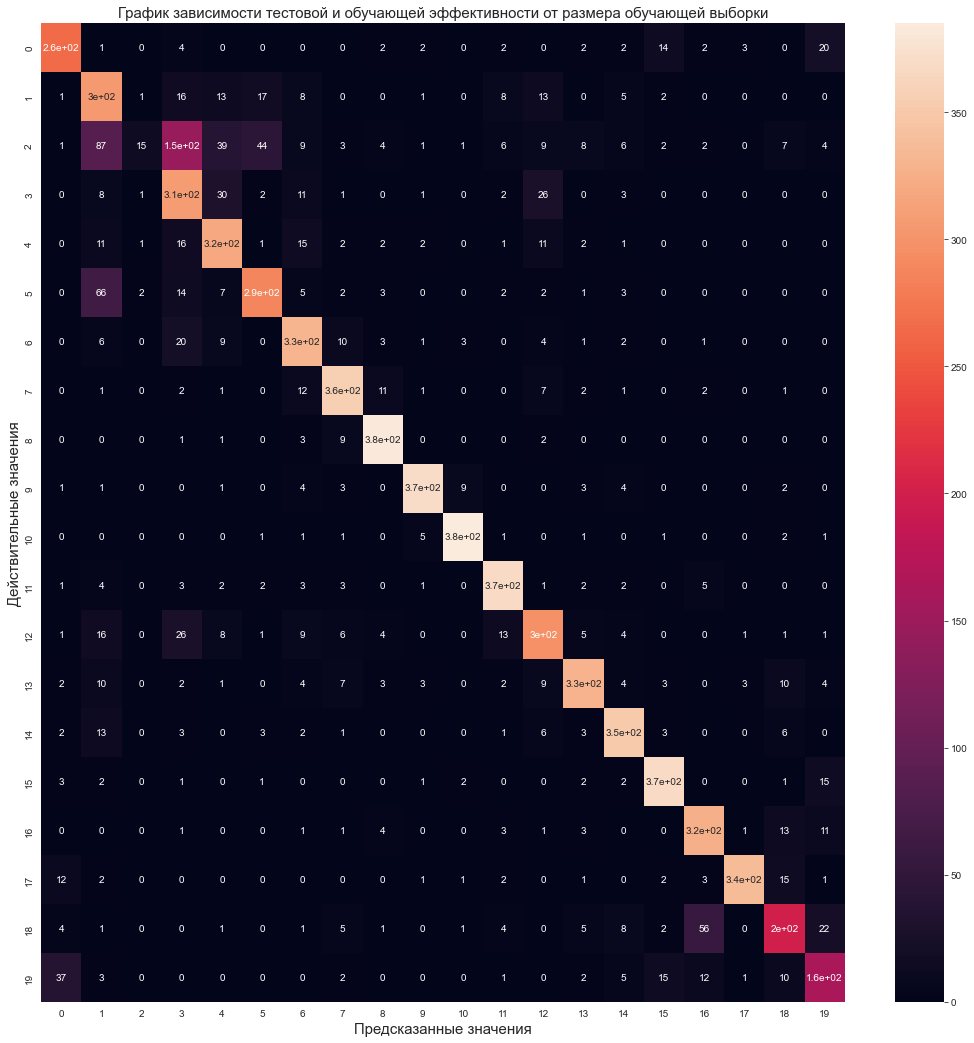

In [62]:
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(pd.DataFrame(metrics.confusion_matrix(dataframe_test.target, data_predict)), annot=True)
plt.title("График зависимости тестовой и обучающей эффективности от размера обучающей выборки", fontsize=15)
plt.ylabel("Действительные значения", fontsize=15)
plt.xlabel("Предсказанные значения", fontsize=15)
plt.show()

##### 8. Постройте кривую обучения - график зависимости тестовой и обучающей эффективности от размера обучающей выборки.

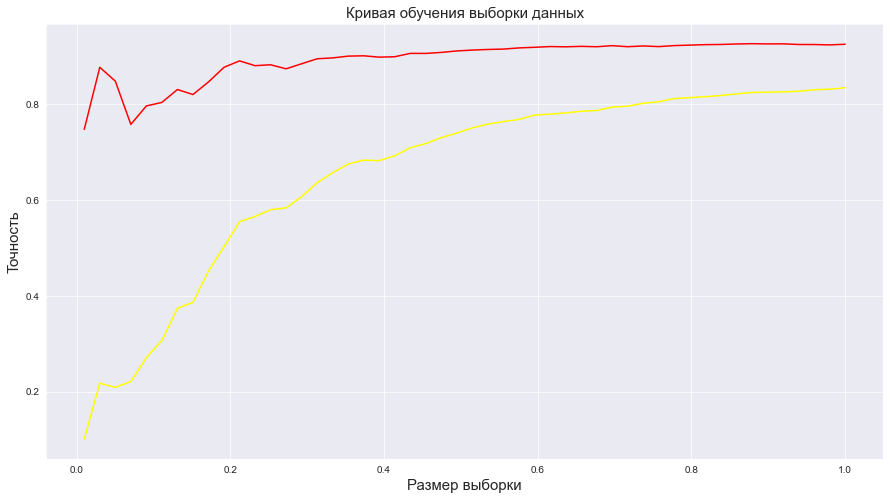

In [66]:
size_grid = np.linspace(0.01, 1.0, 50)
train_size, train_scores, validation_scores = learning_curve(MultinomialNB(), vect_training, dataframe_train.target, train_sizes=size_grid, cv=5)

plt.figure(figsize=(15, 8))
plt.plot(size_grid, np.average(train_scores, axis=1), color='red')
plt.plot(size_grid, np.average(validation_scores, axis=1), color='yellow')
plt.title("Кривая обучения выборки данных", fontsize=15)
plt.xlabel("Размер выборки", fontsize=15)
plt.ylabel("Точность", fontsize=15)
plt.show()

##### 9. Сделайте вывод о применимости модели.

In [67]:
print('Средний итог для вывода : ' + str(round(sum([0.79, 0.81, 0.80]) / 3, 4)))

Средний итог для вывода : 0.8


#### Модель можно применять на исходных данных т.к. точность классификации и среднее значение метрик эффективности состатвляют около 80%